In [11]:
import pandas as pd
import numpy as np
import scipy.stats
from matplotlib import pyplot as plt

import scipy.integrate
from scipy.optimize import fsolve

## Exogenous Selection

In [3]:
class BesleyModel:
    
    def __init__(self, beta = 0.8, pi = 0.5, delta = 0.7, r_min = 0, E = 0.2, q = 0.2, R_max = 1):
        self.beta, self.pi = beta, pi
        self.delta, self.r_min, self.R_max = delta, r_min, R_max
        self.E, self.q = E, q
          
    def G(self, x):
        R_max, r_min = self.R_max, self.r_min
        
        return scipy.stats.uniform.cdf(x, loc = r_min, scale = R_max)
        
    def g(self, x):
        R_max, r_min = self.R_max, self.r_min
        
        return scipy.stats.uniform.pdf(x, loc = r_min, scale = R_max)
        
    def lbda(self, E):
        """
        Probability that dissonant politician does what the electorate wants
        """
        G = self.G
        q, beta = self.q, self.beta
        mu = (self.R_max - self.r_min)/2
        
        return q*G(beta*(mu+E))
    
    def phi(self, E):
        """
        Probability that firm term incumbent generates the good action for voters
        """
        pi = self.pi
        lbda = self.lbda
        
        return pi + (1-pi)*lbda(E)
    
    def Pi(self, E):
        """
        Updated probability that incumbent in congruent instead of dissonant
        conditional on generating a delta benefit in the first period
        """
        phi = self.phi
        pi = self.pi
        
        return pi/phi(E)
    
    def v(self, E):
        """
        Voter welfare viewed from the first period
        """
        delta, beta, pi = self.delta, self.beta, self.pi
        phi = self.phi
        
        return delta/(1-beta) * (phi(E) + pi*beta)/(1+beta*phi(E))
        
        
        

In [4]:
possible_E = np.linspace(0, 0.9, num=100)

#matrix for different pi's, beta's, whatever
possible_pi = [0.4, 0.5, 0.6, 0.7]

prob_congruence = np.empty([len(possible_E), len(possible_pi)])


def compute_prob(possible_E, possible_pi):
    
    for num, pi in enumerate(possible_pi):
        
        for num2, e in enumerate(possible_E):
            
            model=BesleyModel(beta = 0.7, pi = pi)
            prob_congruence[num2, num] = model.phi(E=e)
            
compute_prob(possible_E, possible_pi)

## Prediction 1

An increase in wages increases the probability of congruence between voter preferences and policy outcomes. As a consequence, it reduces turnover among first-term incumbents. 

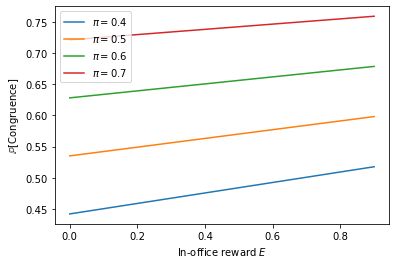

In [5]:
fig, ax = plt.subplots()

for i in range(prob_congruence.shape[1]):
    ax.plot(possible_E, prob_congruence[:,i], label = f'$\pi=${possible_pi[i]}')

    
ax.set_xlabel("In-office reward $E$")
ax.set_ylabel("$\mathbb{P}$[Congruence]")
ax.legend()

## Prediction 2

Conditional on electing a dissonant politician, behavior deteriorates over time. But politicians in their second term in office behave better on average than those in their first term. The difference between second-term and first-term incumbents is smaller the larger the politician's wage. 

In [6]:
possible_E = np.linspace(0, 0.9, num=100)

#matrix for different pi's, beta's, whatever
possible_pi = [0.4, 0.5, 0.6, 0.7]

prob_congruence = np.empty([len(possible_E), len(possible_pi)])


def compute_prob(possible_E, possible_pi):
    
    for num, pi in enumerate(possible_pi):
        
        for num2, e in enumerate(possible_E):
            
            model=BesleyModel(beta = 0.7, pi = pi)
            prob_congruence[num2, num] = (model.pi/model.phi(E=e) - model.phi(E=e))
            
compute_prob(possible_E, possible_pi)

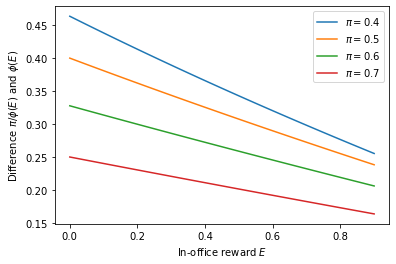

In [7]:
fig, ax = plt.subplots()

for i in range(prob_congruence.shape[1]):
    ax.plot(possible_E, prob_congruence[:,i], label = f'$\pi=${possible_pi[i]}')

    
ax.set_xlabel("In-office reward $E$")
ax.set_ylabel("Difference $\pi/\phi(E)$ and $\phi (E)$")
ax.legend()

## Prediction 3

Increasing $E$ increases voter welfare. 

In [8]:
possible_E = np.linspace(0, 0.9, num=100)

#matrix for different pi's, beta's, whatever
possible_pi = [0.4, 0.5, 0.6, 0.7]

prob_congruence = np.empty([len(possible_E), len(possible_pi)])


def compute_prob(possible_E, possible_pi):
    
    for num, pi in enumerate(possible_pi):
        
        for num2, e in enumerate(possible_E):
            
            model=BesleyModel(beta = 0.7, pi = pi)
            prob_congruence[num2, num] = model.v(e)
            
compute_prob(possible_E, possible_pi)

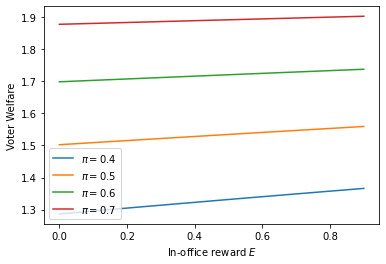

In [9]:
fig, ax = plt.subplots()

for i in range(prob_congruence.shape[1]):
    ax.plot(possible_E, prob_congruence[:,i], label = f'$\pi=${possible_pi[i]}')

    
ax.set_xlabel("In-office reward $E$")
ax.set_ylabel("Voter Welfare")
ax.legend()

## Endogenous Selection

In [97]:
class BesleyModelEndogSel:
    
    def __init__(self, 
                 beta = 0.8, 
                 gamma = 0.5, 
                 E = 0.2, 
                 r_min = 0, R_max = 1,
                 w_max_c = 0.8, w_max_d = 1):
        
        self.beta, self.gamma = beta, gamma
        self.r_min, self.R_max = r_min, R_max
        self.mu = (self.R_max - self.r_min)/2
        self.E = E
        self.w_max_c, self.w_max_d = w_max_c, w_max_d
    
    def G(self, x):
        R_max, r_min = self.R_max, self.r_min
        
        return scipy.stats.uniform.cdf(x, loc = r_min, scale = R_max)
        
    def g(self, x):
        R_max, r_min = self.R_max, self.r_min
        
        return scipy.stats.uniform.pdf(x, loc = r_min, scale = R_max)
        
    def Lbda(self, E, w_bar):
        """
        Probability of congruent behavior by a randomly selected dissonant politician
        (the fraction of dissonant politicians willing to serve)
        """
        G = self.G
        beta = self.beta
        mu = (self.R_max - self.r_min)/2
        
        def integrand(w):
            
            G = self.G
            beta = self.beta
            mu = (self.R_max - self.r_min)/2
            return G(beta*(E+mu) - w)
        
        value = scipy.integrate.quad(integrand, 0, w_bar)[0]
        out = value / w_bar
        
        return out
    
    def Psi(self, x):
        """
        Helper function to solve functional equation
        """
        G, g = self.G, self.g
        beta = self.beta
        
        def integrand(y, x):
            
            G = self.G
            beta = self.beta
            mu = (self.R_max - self.r_min)/2
            
            return y*g(y)/(1+G(beta*x)*beta)
        
        out = - scipy.integrate.quad(integrand, 0, beta*x, args = (x,))[0]
        
        return out
    
    def solve_wbar(self):
        """
        Solve for the reservation wage among dissonant politicians
        """
        Psi = self.Psi
        E = self.E
        mu = self.mu
        
        def tosolve(w_bar, Psi, E, mu):
            
            return w_bar - E - mu - Psi(E + mu - w_bar)
        
        out = fsolve(tosolve, 1e-5, args=(Psi, E, mu))
        
        return out[0]
    
    def share_dissonant(self):
        """
        The share of dissonant politicians who are willing to become politicians
        """
        
        solve_wbar = self.solve_wbar
        w_max_d = self.w_max_d
        
        return(solve_wbar()/w_max_d)
    
    def pi(self):
        """
        Compute the share of consonant politicians in the pool of people willing to become politicians
        """
        E = self.E
        gamma = self.gamma
        solve_wbar = self.solve_wbar
        w_max_c, w_max_d = self.w_max_c, self.w_max_d
        
        w_bar = solve_wbar()
        
        return gamma*(E/w_max_c)/(gamma*(E/w_max_c) + (1-gamma)*(w_bar/w_max_d))
        
        
        

## Prediction 4

Paying higher wages will lead to the increase in the fraction of congruant politicians who will put themselves forward for office

In [100]:
possible_E = np.linspace(0, 0.9, num=50)

#matrix for different pi's, beta's, whatever
possible_gamma = [0.4, 0.5, 0.6, 0.7]

prob_congruence = np.empty([len(possible_E), len(possible_gamma)])


def compute_prob(possible_E, possible_gamma):
    
    for num, gamma in enumerate(possible_gamma):
        
        for num2, e in enumerate(possible_E):
            
            model=BesleyModelEndogSel(beta = 0.7, E = e, gamma = gamma)
            prob_congruence[num2, num] = model.pi()
            
compute_prob(possible_E, possible_gamma)

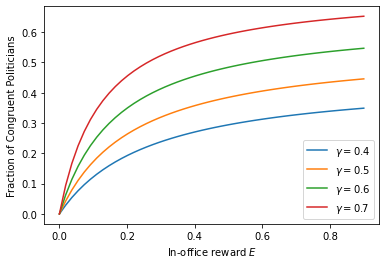

In [102]:
fig, ax = plt.subplots()

for i in range(prob_congruence.shape[1]):
    ax.plot(possible_E, prob_congruence[:,i], label = f'$\gamma=${possible_gamma[i]}')

    
ax.set_xlabel("In-office reward $E$")
ax.set_ylabel("Fraction of Congruent Politicians")
ax.legend()